# Demo of the hybrid algo (alternating WGD + BA steps) on maximum-likelihood deconvolution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
cd ..

/home/yiboyang/projects/eot-descent/public_release


In [4]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [5]:
import numpy as np

In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42  # avoid type 3 fonts; http://phyletica.org/matplotlib-fonts/
matplotlib.rcParams['text.usetex'] = True  # latex font

In [7]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 1.5})

# https://seaborn.pydata.org/tutorial/color_palettes.html
sns.color_palette("colorblind")

# for paper
sns.set_style("whitegrid")

In [8]:
import ml_collections
from tqdm import tqdm

### Set up the experiment for WGD on the BA (rate) functional.

See `bagd/wgd_example.py` for a self-contained implementation without bells & whistles.

In [9]:
import bahybrid.main
expm_cls = bahybrid.main.Experiment

2023-11-01 17:39:12.790411: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/extra/ucibdl0/yiboyang/envs/tf2.10/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/extra/ucibdl0/yiboyang/envs/tf2.10/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/extra/ucibdl0/yiboyang/envs/tf2.10/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/extra/ucibdl0/yiboyang/envs/tf2.10/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/

In [10]:
num_steps = 500
n = 7

In [11]:
config = {
  'ckpt_restore_dir': 'None',
 'train_data_config': {'batchsize': 100000,
  'data_dim': 2,
  'data_spec': 'sphere',  # The \alpha ("no-noise") measure is uniform on a sphere (circle).
  'fixed_batch': True,  # Use a fixed empirical distribution (instead of a new batch per step).
  'gaussian_noise_var': 0.1,  # This is the amount of noise.
  'seed': 0},
 'eval_data_config': {'batchsize': 100000,
  'data_dim': 2,
  'data_spec': 'sphere',
  'fixed_batch': False,
  'gaussian_noise_var': 0.1,
  'seed': 0},
 
 'train_eval_config': {'checkpoint_every_steps': 10000,
  'eval_every_steps': 500,
  'log_imgs_every_steps': None,  # We will log the images ourselves in this demo.
  'log_metrics_every_steps': 10,
  'lr_decay_last_steps_ratio': 0.1,  # Decay lr in the last this proportion of train steps.
  'num_eval_steps': 1,  # Num steps to run in the eval loop.
  'num_train_steps': num_steps,  # Note this sets the lr schedule as well.
  'seed': 0,
  'substeps': 1},
 
 'model_config': {'distort_type': 'half_sse',
  'nu_support_size': n,  # This is the number of particles we use.
  'rd_lambda': 10.0},  # When lambda = 1 / noise_variance, the MLE recovers alpha. See paper Sec 3.
 'optimizer_config': {'args': {},
  'decay_factor': 0.1,
  'decay_type': 'inv_sqrt',
  'learning_rate': 0.01,
  'lr_decay': True,
  'name': 'sgd'},

}

In [12]:
config = ml_collections.ConfigDict(config)

In [13]:
# (Re)-init the experiment
expm = expm_cls(config)

2023-11-01 17:39:15.682366: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-11-01 17:39:15.754424: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Set up code for making 2D scatter / gif; will be called during training

In [14]:
import matplotlib.pyplot as plt

def make_scatter(points_t, weights_t=None, train_X=None, title=None, **scatter_kwargs):
  figsize = (4, 4)
  fig, ax = plt.subplots(figsize=figsize)
  # xlim = ylim = [-2.0, 2.0]
  xlim = ylim = [-1.8, 1.8]
  
  # 1. Scatter data
  legend_elements = []
  if train_X is not None:
    data_scatter = ax.scatter(train_X[:, 0], train_X[:, 1], alpha=0.05, marker='.', color='blue',
                             label='$x \sim \mu$')
    legend_elements.append(data_scatter)
  
  # 2. Plot circle
  circ = plt.Circle((0, 0), 1, color='cyan', fill=False, label='h')
  ax.add_patch(circ)

  # Manually create a legend entry for the circle with a line shape (instead of the shape
  # of a rectangular patch, which looks weird). See https://matplotlib.org/stable/users/explain/axes/legend_guide.html#legend-handlers
  from matplotlib.lines import Line2D
  circ_legend = Line2D([0], [0], color='cyan', lw=2, label=r'$\nu^*$')
  legend_elements.append(circ_legend)

  # 3. Scatter the points to plot
  nu_w = weights_t
  if nu_w is not None:
    # Copied from sphere-vis_nu.ipynb to be consistent
    min_w_to_plot = 0.05  # Set a lower limit, otherwise the color can be too hard to see
    nu_w_c = (1 - min_w_to_plot) * nu_w + min_w_to_plot
    scatter = ax.scatter(points_t[:, 0], points_t[:, 1], c=nu_w_c, vmin=0, **scatter_kwargs)
  else:
    scatter = ax.scatter(points_t[:, 0], points_t[:, 1], **scatter_kwargs)
  legend_elements.append(scatter)

  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  # ax.legend(prop={'size': 13}, loc='upper right')
  ax.legend()
  
  ax.legend(handles=legend_elements, loc='upper right', prop={'size': 12})

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  if title:
    ax.title.set_text(title)
  ax.set_aspect('equal', 'box')
  return fig, ax

(<Figure size 400x400 with 1 Axes>, <Axes: title={'center': 'init'}>)

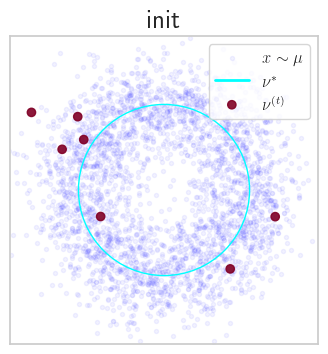

In [15]:
state = expm.state
make_scatter(state.params['nu_x'], state.params['nu_w'], train_X=next(expm.train_iter)[:3000], title='init',
             alpha=0.9, cmap='YlOrRd', label=r'$\nu^{(t)}$')

In [16]:
# Run transparent training loop and log scatter plots to disk.
from plot_utils import make_gif


state = expm.state  # Set during constructor call for Experiment
# eval_train = True  # also estimate (R, D) during training
eval_train = False

# For making gif
tmp_save_path = '/tmp/tmp_imgs/deconv'
if not os.path.exists(tmp_save_path):
  os.makedirs(tmp_save_path)
img_paths = []


nu_xs = []
losses = []

for step in tqdm(range(num_steps)):
  batch = jax.tree_map(jnp.asarray, next(expm.train_iter))
  state, train_metrics = expm.p_train_step(state, batch, eval_train)
  # pprint.pprint(train_metrics['scalars'])
  if step % 10 == 0 or step +1 == num_steps:
    loss = train_metrics['scalars']['loss']
    # print('t=', step, 'loss=', loss)
    
    title = fr'$t={step}, \mathcal{{L}}={loss:.4f}$'
    fig, ax = make_scatter(state.params['nu_x'], state.params['nu_w'], train_X=next(expm.train_iter)[:3000],
                           title=title, label=r'$\nu^{(t)}$', alpha=0.9, cmap='YlOrRd')
                           
    img_path = f'{tmp_save_path}/scatter_{step}.png'
    fig.savefig(img_path)
    plt.close()
    img_paths.append(img_path)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 41.06it/s]


In [17]:
gif_path = f'{tmp_save_path}/scatters.gif'
# Have a little pause at the beginning and end
gif_img_paths = img_paths[0:1]*10 + img_paths + img_paths[-1:]*10
duration_per_img = 0.06

make_gif(gif_img_paths, gif_path, duration_per_img=duration_per_img)

print("Generated gif at", gif_path)

Generated gif at /tmp/tmp_imgs/deconv/scatters.gif


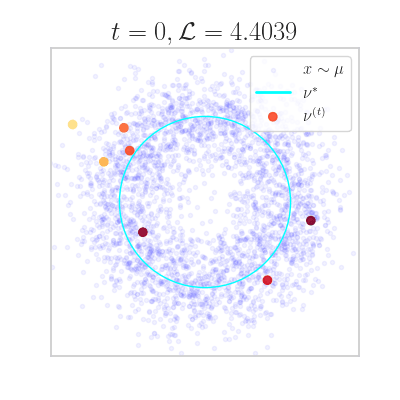

In [18]:
from IPython.display import Image, display
display(Image(filename=gif_path, width=500, height=500))

In [19]:
!cp /tmp/tmp_imgs/deconv/scatters.gif results/deconv/nu_vs_t-method=hybrid-n=7-lamb=10.gif